In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataframe = pd.read_csv("./WineQT.csv")
dataframe.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<Axes: >

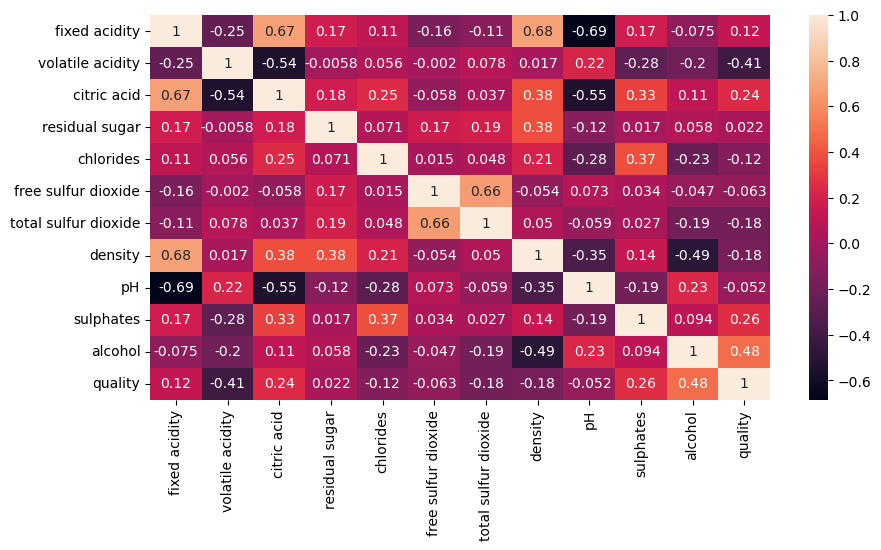

In [3]:
plt.figure(figsize=(10, 5))
sns.heatmap(dataframe.corr(), annot=True)

In [4]:
def high_corr(df, threshold):
    cols = set()
    df_corr = df.corr()
    for i in range(len(df_corr.columns)):
        for j in range(i + 1, len(df_corr.columns)):
            if abs(df_corr.iloc[i, j] >= threshold):
                cols.add(df_corr.columns[j])
                cols.add(df_corr.columns[i])
    return cols


high_corr(dataframe, 0.85)

set()

In [5]:
dataframe.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [6]:
cols = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]

mask = np.ones(dataframe.shape[0], dtype=bool)

for col in cols:
    Q1 = np.percentile(dataframe[col], 25)
    Q3 = np.percentile(dataframe[col], 75)
    IQR = Q3 - Q1
    lowerWhisker = Q1 - 1.5 * IQR
    upperWhisker = Q3 + 1.5 * IQR
    mask &= (dataframe[col] >= lowerWhisker) & (dataframe[col] <= upperWhisker)

dataframe = dataframe[mask].reset_index(drop=True)
dataframe.shape

(848, 12)

In [7]:
dataframe["quality"].value_counts()

quality
5    362
6    359
7     94
4     19
8     11
3      3
Name: count, dtype: int64

In [8]:
X = dataframe.drop(columns=["quality"], axis=1)
y = dataframe["quality"]
X.shape, y.shape

((848, 11), (848,))

In [9]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=2)
X, y = smote.fit_resample(X, y)
y.value_counts()

quality
5    362
6    362
7    362
4    362
8    362
3    362
Name: count, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.25
)

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
from sklearn.svm import SVC

svm_classifier = SVC()
svm_classifier.fit(X_train_scaled, y_train)
y_pred = svm_classifier.predict(X_test_scaled)

In [13]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[87  0  0  0  0  0]
 [ 0 84  0  0  0  0]
 [ 2  8 62 19  1  0]
 [ 0 11 27 45 14  3]
 [ 0  0  0 16 73  8]
 [ 0  0  0  0  0 83]]
              precision    recall  f1-score   support

           3       0.98      1.00      0.99        87
           4       0.82      1.00      0.90        84
           5       0.70      0.67      0.69        92
           6       0.56      0.45      0.50       100
           7       0.83      0.75      0.79        97
           8       0.88      1.00      0.94        83

    accuracy                           0.80       543
   macro avg       0.79      0.81      0.80       543
weighted avg       0.79      0.80      0.79       543



# Hyper Parameter Tuning


In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": [1, 2, 3, 4, 5],
    "gamma": ["scale", "auto"],
}
gridSearch = GridSearchCV(param_grid=param_grid, estimator=svm_classifier, cv=5)

In [15]:
gridSearch.fit(X_train_scaled, y_train)
gridSearch.best_params_

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'C': 100, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}

In [16]:
# Using Best Parameters in SVM
svc_bestParams = SVC(C=100, degree=1, gamma="auto", kernel="rbf")
svc_bestParams.fit(X_train_scaled, y_train)
y_pred_best = svc_bestParams.predict(X_test_scaled)

from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

[[87  0  0  0  0  0]
 [ 0 84  0  0  0  0]
 [ 2  7 63 19  1  0]
 [ 0  6 37 44 12  1]
 [ 0  0  1  9 86  1]
 [ 0  0  0  0  0 83]]
              precision    recall  f1-score   support

           3       0.98      1.00      0.99        87
           4       0.87      1.00      0.93        84
           5       0.62      0.68      0.65        92
           6       0.61      0.44      0.51       100
           7       0.87      0.89      0.88        97
           8       0.98      1.00      0.99        83

    accuracy                           0.82       543
   macro avg       0.82      0.84      0.82       543
weighted avg       0.81      0.82      0.81       543

